In [1]:
import os
import getpass
from neo4j import GraphDatabase, Result
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Neo4jVector
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from llama_index.core.schema import TextNode
from llama_index.core.vector_stores.utils import node_to_metadata_dict
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from llama_index.core import VectorStoreIndex
from tqdm import tqdm

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "password"))

In [13]:
def db_query(cypher: str, params: dict[str, any] = {}) -> pd.DataFrame:
    """Executes a Cypher statement and returns a DataFrame"""
    return driver.execute_query(
        cypher, parameters_=params, result_transformer_=Result.to_df
    )

In [14]:
db_query(
  "MATCH (n:__Chunk__) RETURN n.n_tokens as token_count, count(*) AS count"
)

,token_count,count
0,300,230
1,155,1


In [15]:
db_query(
  "MATCH (n:__Entity__) RETURN n.name AS name, n.description AS description LIMIT 1"
)

,name,description
0,PROJECT GUTENBERG,Project Gutenberg is a pioneering organization...


In [22]:
db_query(
  "MATCH ()-[n:RELATED]->() RETURN n.description AS description LIMIT 5"
)

,description
0,"""Project Gutenberg is responsible for releasin..."
1,"""Suzanne Shell produced the eBook version of '..."
2,"""Janet Blenkinship produced the eBook version ..."
3,Project Gutenberg operates within the United S...
4,"""Project Gutenberg establishes and enforces th..."


In [23]:
db_query("""
  MATCH (n:__Community__) 
  RETURN n.title AS title, n.summary AS summary, n.full_content AS full_content LIMIT 1
""")

,title,summary,full_content
0,The Cratchit Family: A Study of Resilience and...,"The Cratchit family, central to the narrative,...",# The Cratchit Family: A Study of Resilience a...


In [24]:
entity_df_2 = db_query(
    """
MATCH (d:__Chunk__)
RETURN count {(d)-[:HAS_ENTITY]->()} AS entity_count
"""
)

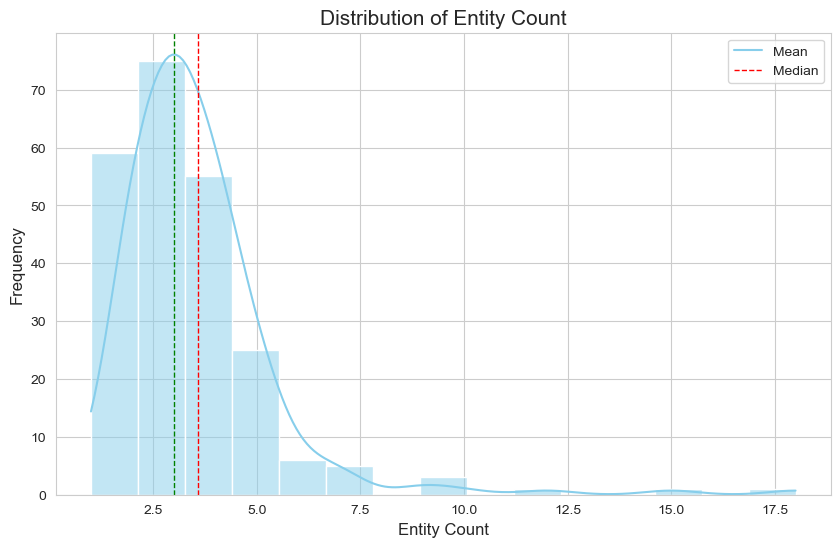

3.588744588744589
3.0


In [20]:
# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(entity_df_2['entity_count'], kde=True, bins=15, color='skyblue')
plt.axvline(entity_df_2['entity_count'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(entity_df_2['entity_count'].median(), color='green', linestyle='dashed', linewidth=1)
plt.xlabel('Entity Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Entity Count', fontsize=15)
plt.legend({'Mean': entity_df_2['entity_count'].mean(), 'Median': entity_df_2['entity_count'].median()})
plt.show()

print(entity_df_2['entity_count'].mean())
print(entity_df_2['entity_count'].median())

In [36]:
degree_dist_df = db_query(
    """
MATCH (e:__Entity__)
RETURN e.name, count {(e)-[:RELATED]-()} AS node_degree
ORDER BY node_degree DESC
    """
)

display(degree_dist_df.head(10))

,e.name,node_degree
0,SCROOGE,120
1,MRS. CRATCHIT,16
2,BOB CRATCHIT,14
3,PROJECT GUTENBERG,13
4,EBENEZER SCROOGE,12
5,CHRISTMAS,12
6,FEZZIWIG,11
7,THE GHOST,11
8,TINY TIM,11
9,BOB,11


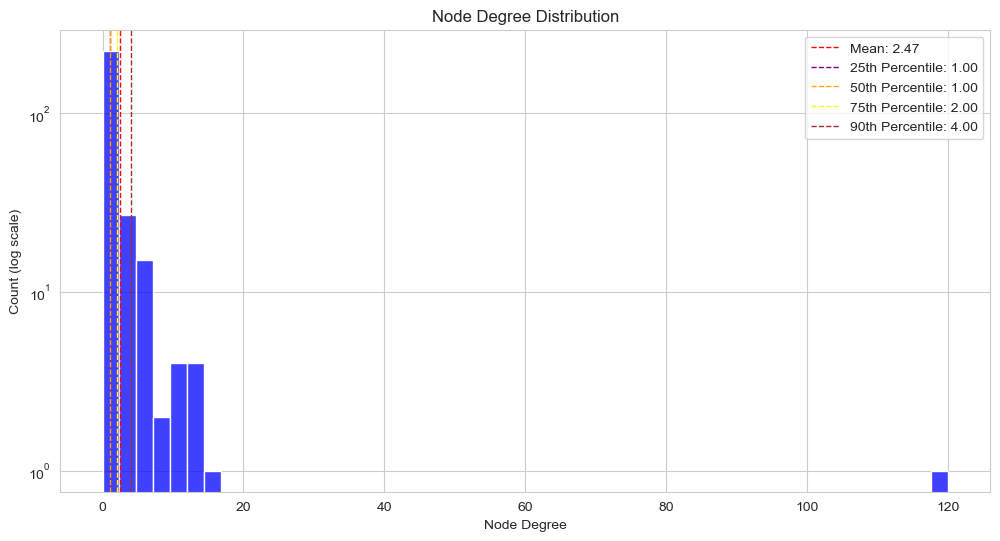

2.4693140794223827
1.0


In [28]:
#Calculate mean and median
mean_degree = np.mean(degree_dist_df['node_degree'])
percentiles = np.percentile(degree_dist_df['node_degree'],[25,50,75,90])

#Create a histogram with a logarithmic scale
plt.figure(figsize=(12,6))
sns.histplot(degree_dist_df['node_degree'], bins=50, kde=False, color="blue")
plt.yscale('log')
plt.xlabel('Node Degree')
plt.ylabel('Count (log scale)')
plt.title("Node Degree Distribution")

#Add central tendency/percentile lines
plt.axvline(mean_degree, color="red", linestyle="dashed", linewidth=1, label=f'Mean: {mean_degree:.2f}')
plt.axvline(percentiles[0], color="purple", linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentiles[0]:.2f}')
plt.axvline(percentiles[1], color="orange", linestyle='dashed', linewidth=1, label=f'50th Percentile: {percentiles[1]:.2f}')
plt.axvline(percentiles[2], color="yellow", linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentiles[2]:.2f}')
plt.axvline(percentiles[3], color="brown", linestyle="dashed", linewidth=1, label=f'90th Percentile: {percentiles[3]:.2f}')

plt.legend()
plt.show()

print(degree_dist_df['node_degree'].mean())
print(degree_dist_df['node_degree'].median())

In [7]:
db_query = ("""
MATCH (n:__Entity__)-[:RELATED]->()
WHERE node_degree = 120
RETURN (n)
""")